In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install emoji
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk. corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

import pickle

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/InfosysSpringboard/dataset/cyberbullying_tweets.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
df['cyberbullying_type'].value_counts()

,count
cyberbullying_type,
religion,7998
age,7992
gender,7973
ethnicity,7961
not_cyberbullying,7945
other_cyberbullying,7823


removing the "other_cyberbullying" class

In [7]:
df= df[df['cyberbullying_type'] != 'other_cyberbullying']

In [8]:
df['cyberbullying_type'].value_counts()

,count
cyberbullying_type,
religion,7998
age,7992
gender,7973
ethnicity,7961
not_cyberbullying,7945


In [9]:
df.isnull().sum()

,0
tweet_text,0
cyberbullying_type,0


In [10]:
df=df.rename(columns={'tweet_text':'text'})
df['type_encoded'] = df['cyberbullying_type'].replace({
    'religion':1,
    'age':2,
    'gender':3,
    'ethnicity':4,
    'not_cyberbullying':5
})

<ipython-input-10-54d47414fe81>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['type_encoded'] = df['cyberbullying_type'].replace({


In [11]:
df.head()

,text,cyberbullying_type,type_encoded
0,"In other words #katandandre, your food was cra...",not_cyberbullying,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,5
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,5
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,5


In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stop_words = set(stopwords.words('english'))

In [14]:
#removing the emoji
def strip_emoji(text):
  return emoji.replace_emoji(text,replace="")

In [15]:
# function to convert to lowercase, remove urls, stopwords

def strip_all_entities(text):

  text = text.replace('\r', '').replace('\n','').lower()
  text = re.sub(r"(?:\@|https?|-\://)\S+",'',text)
  text = re.sub(r"[^\x00-\x7f]",r'',text)
  text = re.sub('[0-9]','',text)

  stopchars = string.punctuation
  table=str.maketrans('','',stopchars)
  text = text.translate(table)

  text = [word for word in text.split() if word not in stop_words]
  text=' '.join(text)

  return text

In [16]:
#function to remove contarcitons

def decontract(text):

  text = re.sub(r"cant\'t", "can not", text)
  text = re.sub(r"n\'t", "not", text)
  text = re.sub(r"\'re", "are", text)
  text = re.sub(r"\'s", "is", text)
  text = re.sub(r"\'d", "would", text)
  text = re.sub(r"\'ll", "will", text)
  text = re.sub(r"\'t", "not", text)
  text = re.sub(r"\'ve", "have", text)
  text = re.sub(r"\'m", "am", text)

  return text

In [17]:
#remove hashtags
def clean_hashtags(tweet):

  new_tweet =" ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)',tweet))
  new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))

  return new_tweet2

In [18]:
#function to flter special characters

def filter_chars(a):
  sent = []
  for word in a.split(' '):
    if ('$' in word) | ('&' in word):
      sent.append('')
    else:
      sent.append(word)
  return ' '.join(sent)


In [19]:
# removing sequesees and appluing stemming

def remove_mult_spaces(text):
  return re.sub("\s\s+", " ", text)

def stemmer(text):
  tokenized = nltk.word_tokenize(text)
  ps = PorterStemmer()
  return ' '.join([ps.stem(words) for words in tokenized])

def lemmatize(text):
  tokenized = nltk.word_tokenize(text)
  lm = WordNetLemmatizer()
  return ' '.join([lm.lemmatize(words) for words in tokenized])

In [20]:
# using all functions

def preprocess(text):
  text = strip_emoji(text)
  text = decontract(text)
  text = strip_all_entities(text)
  text = clean_hashtags(text)
  text = filter_chars(text)
  text = remove_mult_spaces(text)
  text = stemmer(text)
  text = lemmatize(text)

  return text

In [21]:
df['cleaned_text'] = df['text'].apply(preprocess)
df.head()

,text,cyberbullying_type,type_encoded,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,5,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,5,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,5,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,5,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,5,isi account pretend kurdish account like islam...


In [22]:
#dealing duplicates
df['cleaned_text'].duplicated().sum()

964

In [23]:
df.drop_duplicates('cleaned_text', inplace=True)

In [24]:
#tokenization
df['tweet_list'] = df['cleaned_text'].apply(word_tokenize)
df.head()

,text,cyberbullying_type,type_encoded,cleaned_text,tweet_list
0,"In other words #katandandre, your food was cra...",not_cyberbullying,5,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,5,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,5,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,5,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,5,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like..."


EDA

In [25]:
#EDA
#checking lenght of various tweet text
text_len = []
for text in df.tweet_list:
  tweet_len = len(text)
  text_len.append(tweet_len)
df['text_len'] = text_len

<ipython-input-26-6926557a328f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df, palette='mako')


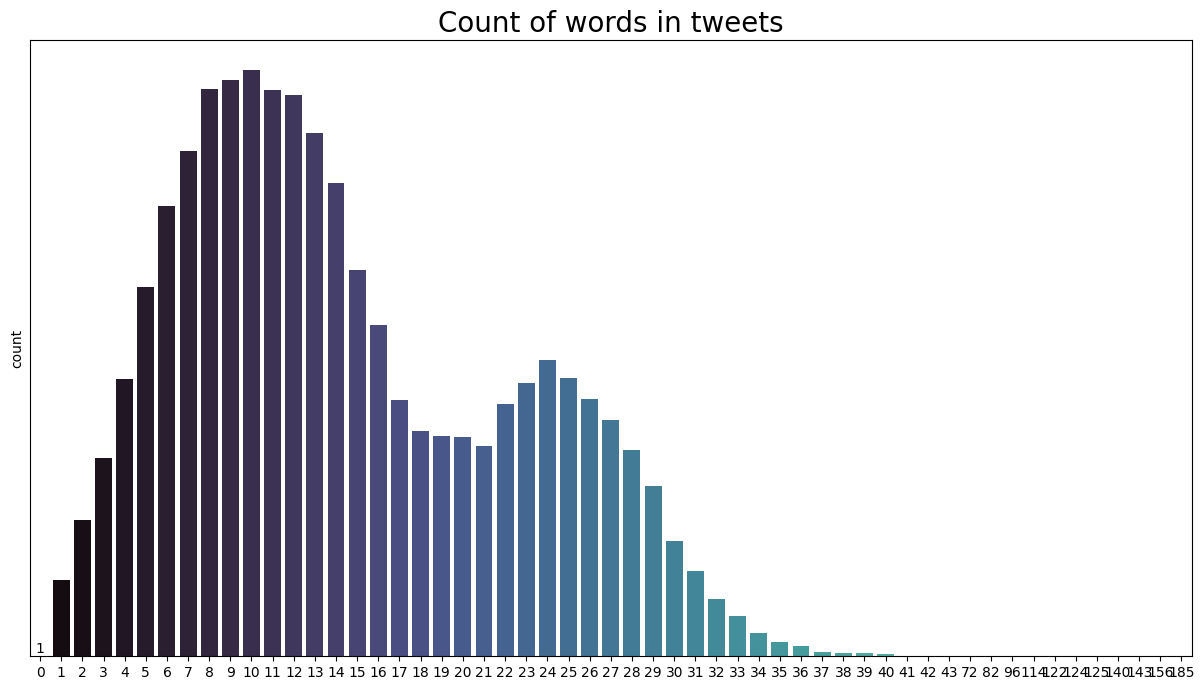

In [26]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=df, palette='mako')
plt.title('Count of words in tweets', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [27]:
#removing text without words
df = df[df['text_len']!=0]

In [28]:
df.shape

(38904, 6)

In [29]:
#function to create a word cloud

def plot_wordcloud(cyberbullying_type):
  string = ""
  for i in df[df.cyberbullying_type == cyberbullying_type].cleaned_text.values:
    string = string + " " + i.strip()


    #cusom __>
    #mask  __>
  wordcloud = WordCloud(background_color = 'white', max_words = 2500, max_font_size = 256, random_state=42).generate(string)

  plt.figure(figsize = (8,8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.title(cyberbullying_type)
  plt.show()
  del string

In [30]:
#splitting data based on sentiment for EDA

not_cyberbullying_type = df[df['cyberbullying_type']=='not_cyberbullying']
gender_type = df[df['cyberbullying_type']=='gender']
religion_type = df[df['cyberbullying_type']=='religion']
other_cyberbullying_type = df[df['cyberbullying_type']=='other_cyberbullying']
age_type = df[df['cyberbullying_type']=='age']
ethnicity_type = df[df['cyberbullying_type']=='ethnicity']

In [31]:
gender = Counter([item for sublist in gender_type['tweet_list'] for item in sublist])
top20_gender = pd.DataFrame(gender.most_common(20))
top20_gender.columns = ['Top Words', 'Count']
top20_gender.style.background_gradient(cmap='Greens')

,Top Words,Count
0,joke,5180
1,rape,4072
2,gay,3851
3,call,1401
4,make,1286
5,rt,1219
6,bitch,1145
7,woman,1110
8,femal,1107
9,like,978


Text(0.5, 1.0, 'Top20 words in Gender Cyberbullying')

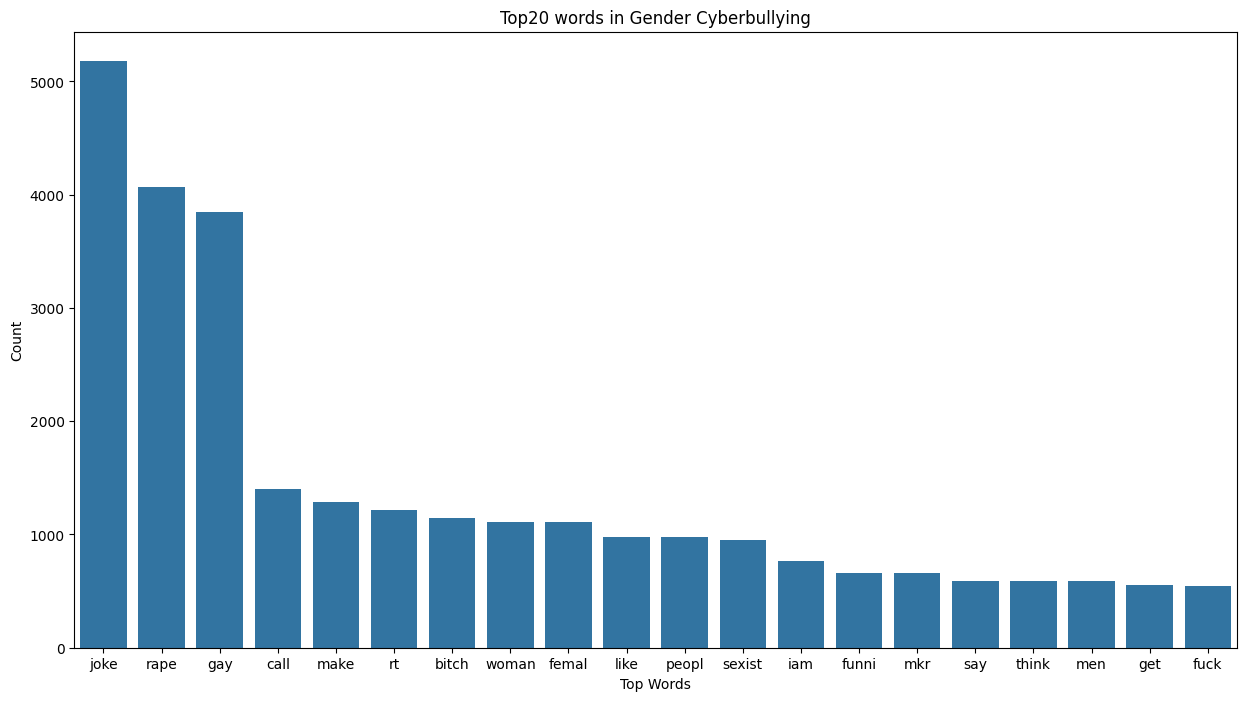

In [32]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_gender, y="Count", x="Top Words")
plt.title("Top20 words in Gender Cyberbullying")

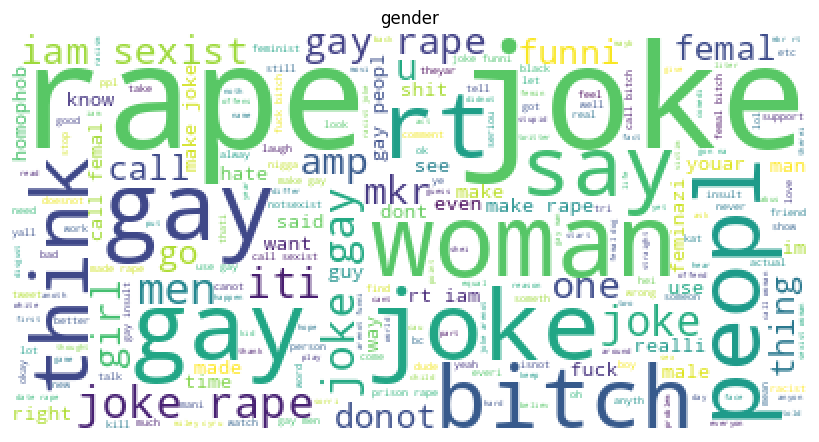

In [33]:
plot_wordcloud('gender')

In [34]:
religion = Counter([item for sublist in religion_type['tweet_list'] for item in sublist])
top20_religion = pd.DataFrame(religion.most_common(20))
top20_religion.columns = ['Top Words', 'Count']
top20_religion.style.background_gradient(cmap='Greens')

,Top Words,Count
0,muslim,4600
1,idiot,3067
2,islam,2426
3,christian,2123
4,u,1919
5,terrorist,1374
6,right,1288
7,like,1276
8,support,1250
9,woman,1225


Text(0.5, 1.0, 'Top 20 words in Religion Cyberbullying')

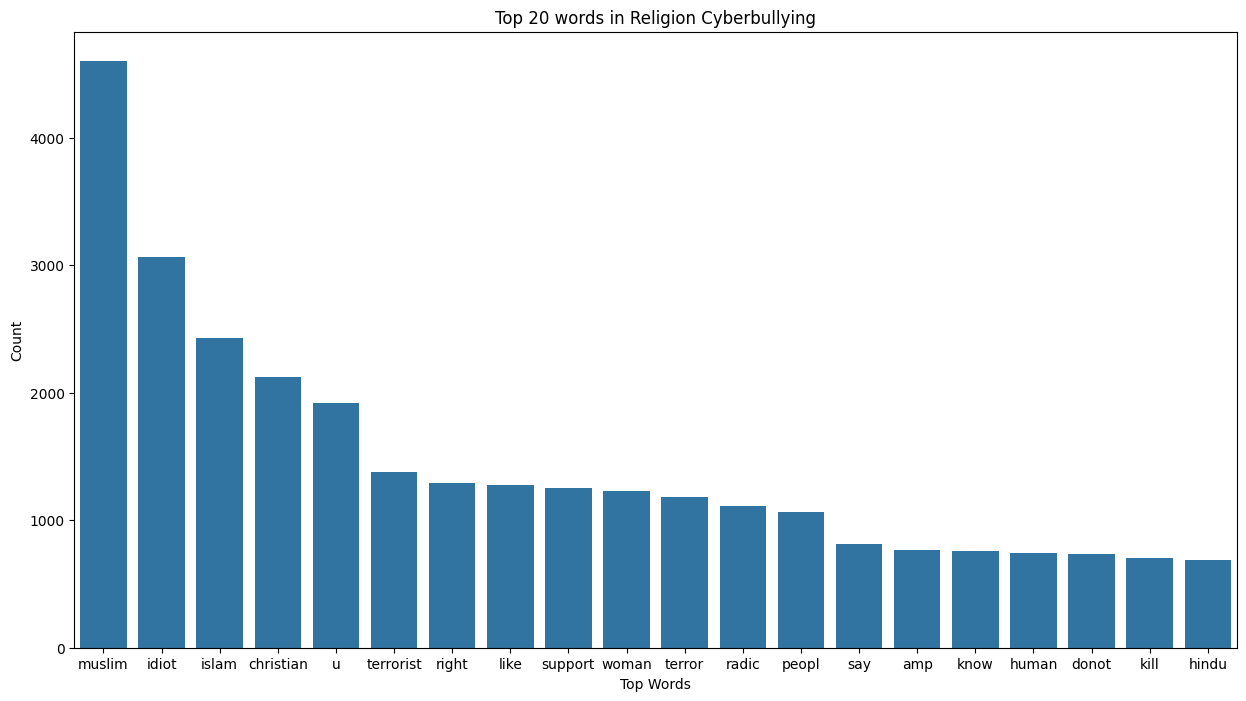

In [35]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_religion, y="Count", x="Top Words")
plt.title("Top 20 words in Religion Cyberbullying")

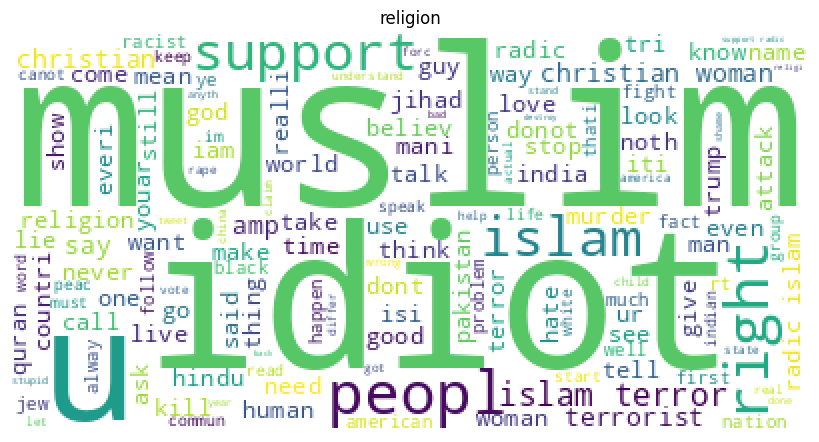

In [36]:
plot_wordcloud('religion')

In [37]:
#age based cyber bullying

In [38]:
age = Counter([item for sublist in age_type['tweet_list'] for item in sublist])
top20_age = pd.DataFrame(age.most_common(20))
top20_age.columns = ['Top Words', 'Count']
top20_age.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,8895
1,school,8423
2,high,4861
3,girl,4605
4,like,2080
5,get,1052
6,one,1040
7,peopl,928
8,got,842
9,kid,805


Text(0.5, 1.0, 'Top 20 words in Age Cyberbullying')

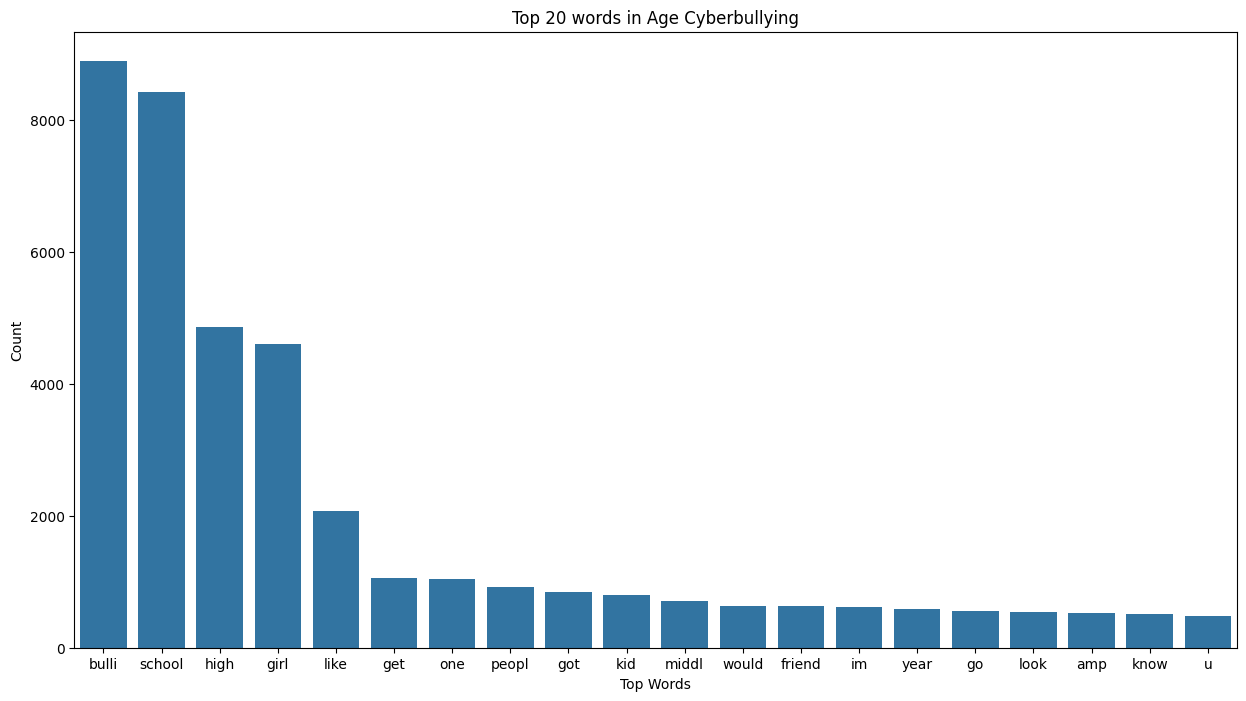

In [39]:
fig = plt.figure(figsize = (15,8))
sns.barplot(data=top20_age, y="Count", x="Top Words")
plt.title("Top 20 words in Age Cyberbullying")

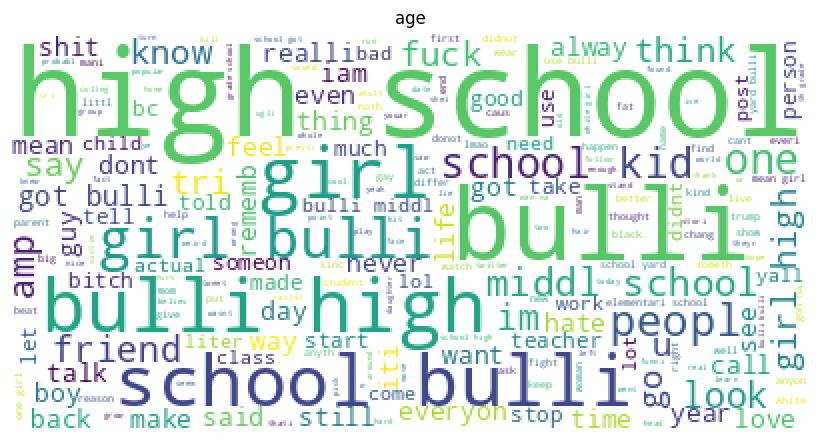

In [40]:
plot_wordcloud('age')

In [41]:
#ethnocity based cyber bullying

In [42]:
ethnicity = Counter([item for sublist in ethnicity_type['tweet_list'] for item in sublist])
top20_ethnicity = pd.DataFrame(ethnicity.most_common(20))
top20_ethnicity.columns = ['Top Words', 'Count']
top20_ethnicity.style.background_gradient(cmap='Greens')

,Top Words,Count
0,fuck,5890
1,nigger,5454
2,dumb,5006
3,as,2241
4,black,2132
5,u,2099
6,white,1557
7,call,1381
8,peopl,1179
9,rt,1163


Text(0.5, 1.0, 'Top 20 words in Ethnicity Cyberbullying')

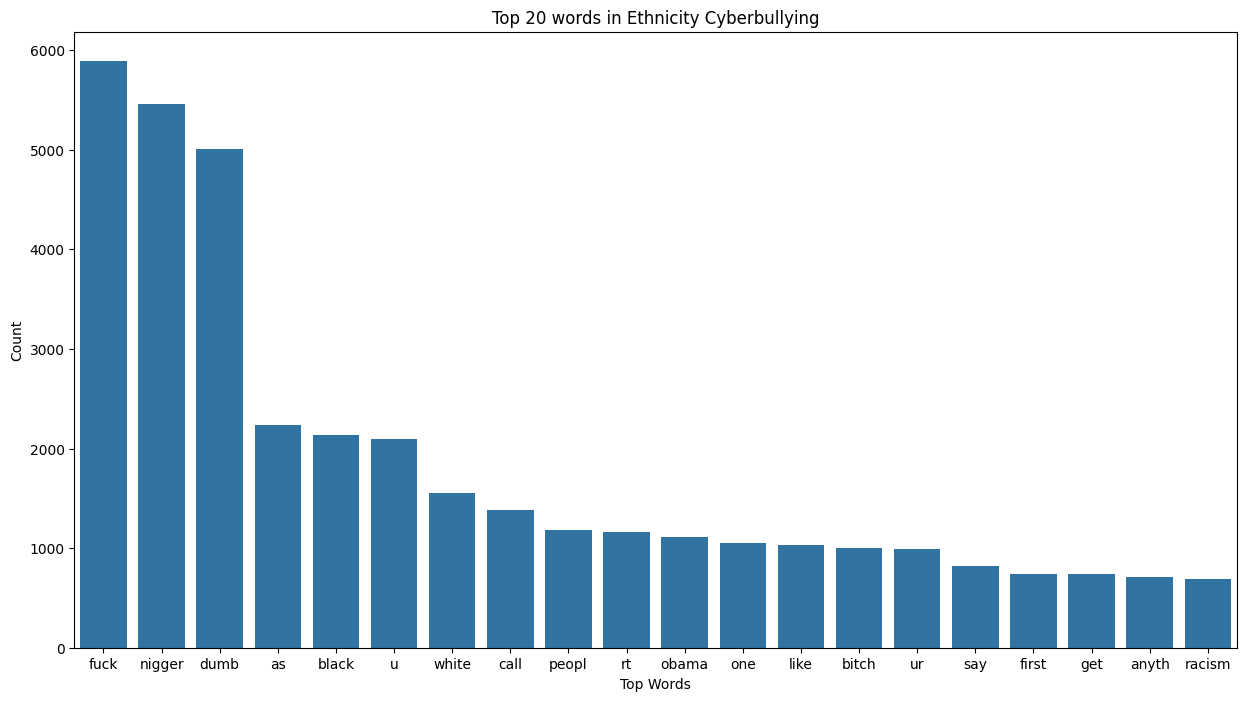

In [43]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_ethnicity, y="Count", x="Top Words")
plt.title("Top 20 words in Ethnicity Cyberbullying")

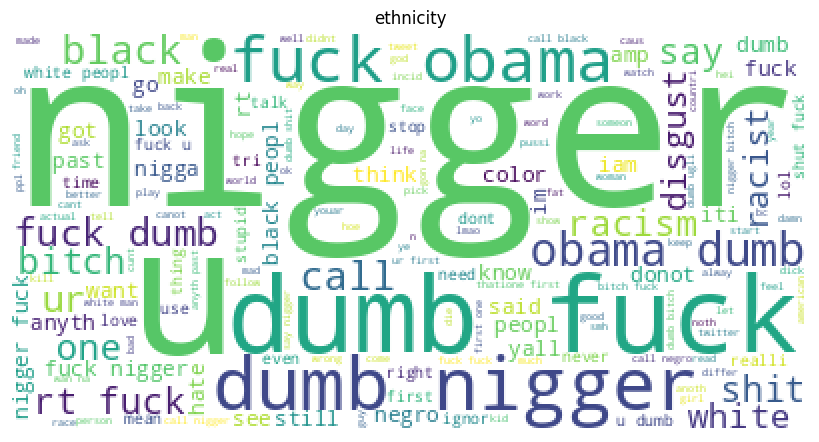

In [44]:
plot_wordcloud('ethnicity')

In [46]:
#twets with no cyber bullying
not_cyberbullying = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
top20_not_cyberbullying = pd.DataFrame(not_cyberbullying.most_common(20))
top20_not_cyberbullying.columns = ['Top Words', 'Count']
top20_not_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,mkr,1666
1,bulli,1095
2,rt,781
3,like,424
4,get,420
5,iam,413
6,go,395
7,school,374
8,donot,338
9,iti,333


Text(0.5, 1.0, 'Top 20 words in not Cyberbullying')

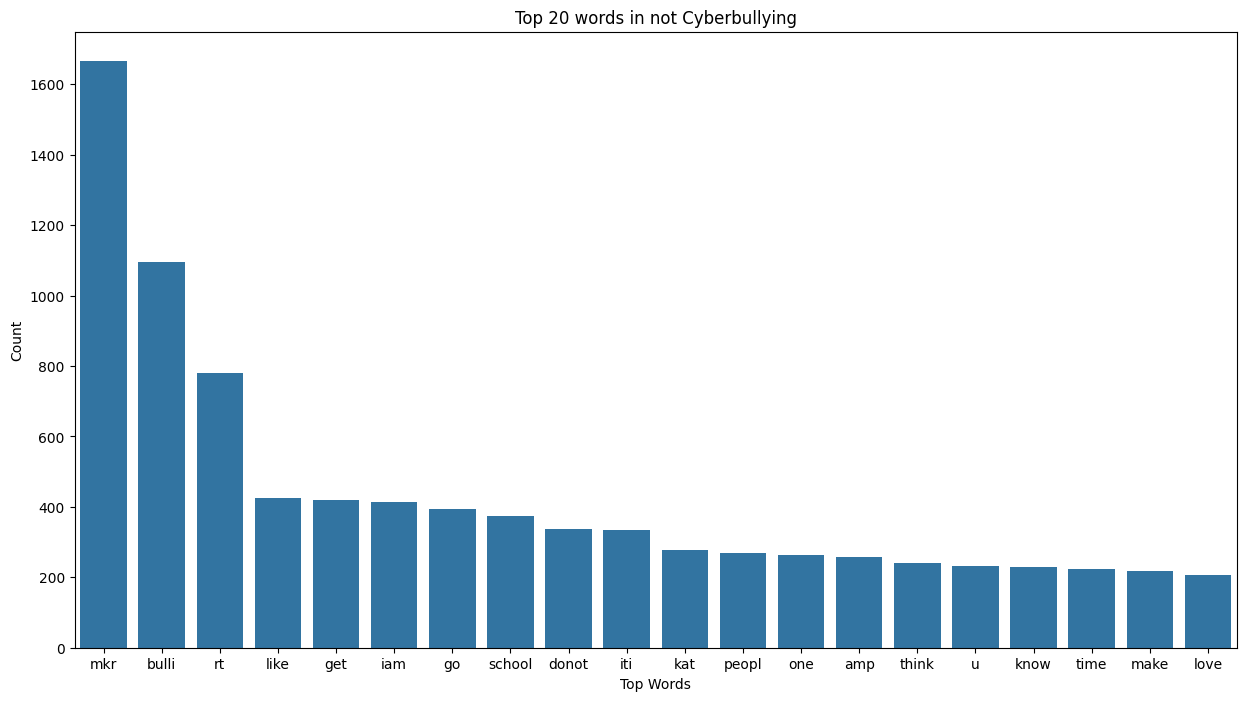

In [49]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_not_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in not Cyberbullying")

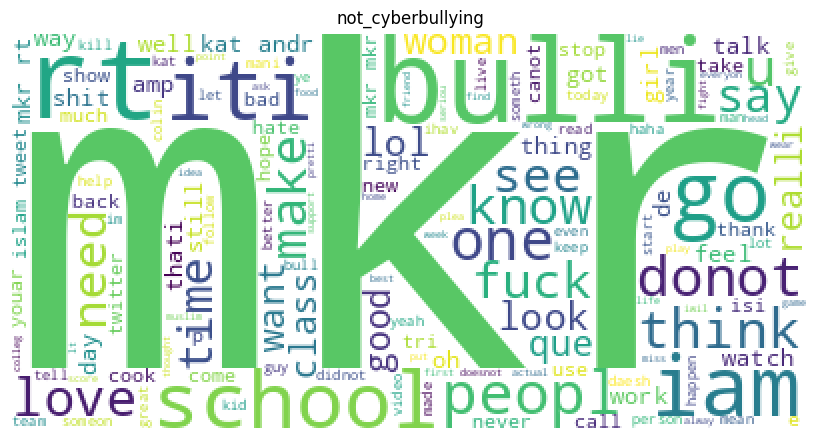

In [50]:
plot_wordcloud('not_cyberbullying')

In [51]:
df.head()

,text,cyberbullying_type,type_encoded,cleaned_text,tweet_list,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,5,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,5,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,5,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,5,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d...",9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,5,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like...",8


In [53]:
sentiments = ["religion", "age", "ethnicity", "gender", "not_cyberbullying"]

In [54]:
#modelling

In [56]:
# splitting data in test and train
X, Y  = df['cleaned_text'],df['type_encoded']

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, stratify = Y, random_state = 42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(27232,) (27232,) (11672,) (11672,)


In [59]:
# tf - idf vectorization
tf_idf = TfidfVectorizer()
x_train_tf=tf_idf.fit_transform(x_train)
x_test_tf = tf_idf.transform(x_test)
print(x_train_tf.shape)
print(x_test_tf.shape)

(27232, 28021)
(11672, 28021)


In [60]:
#trying different models

In [61]:
#logistics
log_reg = LogisticRegression()

In [63]:
log_cv_score = cross_val_score(log_reg,x_train_tf, y_train, cv=5,scoring='f1_macro',n_jobs=1)

In [64]:
mean_log_cv = np.mean(log_cv_score)
mean_log_cv

0.9192465410595375

In [65]:
lin_svc = LinearSVC()

In [67]:
lin_svc_cv_score = cross_val_score(lin_svc, x_train_tf, y_train, cv=5, scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv

0.9193715496704151

In [68]:
#naive bayes classifier

In [69]:
multiNB = MultinomialNB()

In [70]:
multiNB_cv_score = cross_val_score(multiNB, x_train_tf, y_train,cv=5, scoring='f1_macro',n_jobs=-1)
mean_multiNB_cv = np.mean(multiNB_cv_score)
mean_multiNB_cv

0.8165878746823859

In [71]:
#decision tree classifier

In [72]:
dtree = DecisionTreeClassifier()

In [73]:
dtree_cv_score = cross_val_score(dtree,x_train_tf, y_train,cv=5, scoring='f1_macro',n_jobs=-1)
mean_dtree_cv = np.mean(dtree_cv_score)
mean_dtree_cv

0.9143198650297

In [74]:
#random forest

In [75]:
rand_forest = RandomForestClassifier()

In [76]:
rand_forest_cv_score = cross_val_score(rand_forest,x_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_rand_forest_cv=np.mean(rand_forest_cv_score)
mean_rand_forest_cv

0.932765391365662

In [77]:
#ada boost classifier

In [79]:
from sklearn.ensemble import AdaBoostClassifier
adab = AdaBoostClassifier()

In [80]:
adab_cv_score = cross_val_score(adab,x_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_adab_cv = np.mean(adab_cv_score)
mean_adab_cv

0.8937716158248558

In [81]:
#by trying different models we can see logistic regression, svm and random forest classifier performed similarly

In [82]:
#tuning SVC

In [83]:
svc1 =LinearSVC()
param_grid = {'C':[0.001,0.001,0.01,0.1,1,10],
              'loss':['hinge','squared_hinge'],
              'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid, cv=5,scoring = 'f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(x_train_tf,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [84]:
grid_search.best_estimator_

LinearSVC(C=1, loss='hinge')

In [85]:
grid_search.best_score_

0.922646755531991

In [86]:
lin_svc.fit(x_train_tf,y_train)
y_pred = lin_svc.predict(x_test_tf)

In [91]:
def print_confusion_matrix(confusion_matrix, class_names, figsize=(10,7), fontsize=14):
  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
  fig = plt.figure(figsize=figsize)
  try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  except ValueError:
    raise ValueError("Confusion matrix values must be intergers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize = fontsize)
  plt.ylabel('Truth')
  plt.xlabel('Prediction')

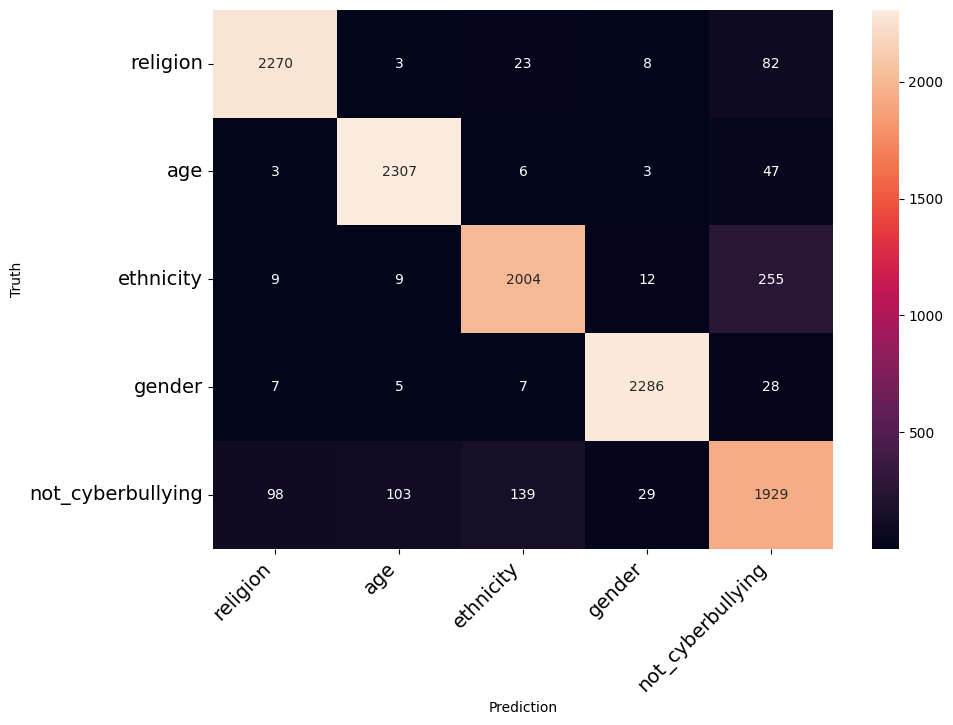

In [92]:
cm = confusion_matrix(y_test, y_pred)
print_confusion_matrix(cm, sentiments)

In [93]:
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=sentiments))

Classification Report:
                    precision    recall  f1-score   support

         religion       0.95      0.95      0.95      2386
              age       0.95      0.98      0.96      2366
        ethnicity       0.92      0.88      0.90      2289
           gender       0.98      0.98      0.98      2333
not_cyberbullying       0.82      0.84      0.83      2298

         accuracy                           0.92     11672
        macro avg       0.92      0.92      0.92     11672
     weighted avg       0.93      0.92      0.92     11672

